### cluster

In [1]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
# print(plt.style.available)
plt.style.use('seaborn-v0_8-bright')
sns.set_palette("hls")

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KernelDensity, NearestNeighbors
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.stats import norm 
from scipy.cluster.hierarchy import linkage, dendrogram


from sklearn.decomposition import PCA
# SOM

from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score

import warnings
warnings.filterwarnings('ignore')

In [4]:
# 데이터 불러오기
df_raw = pd.read_csv('./data/Mall_Customers.csv')
# df_raw.head()
del df_raw['CustomerID']

# # row 200개
# # col 5개 (ID, 성별, 나이, 연간소득, 소비지수)
print(f"data's shape : {df_raw.shape}\n")

# # gender 제외 모두 수치형
df_raw.info()

data's shape : (200, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


In [5]:
# 거리 계산 위해 gender는 one-hot encoding 해주기
df = df_raw.copy()
df['Gender'].replace({'Male':0, 'Female':1}, inplace=True)

# sklearn OneHotEncoder
# gender = np.array(df['Gender']).reshape(200,1)
# enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# enc.fit(gender)
# enc.categories_
# df['Gender'] =  enc.transform(gender)

In [6]:
df.isnull().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [7]:
df.describe()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,0.560000,38.850000,60.560000,50.200000
std,0.497633,13.969007,26.264721,25.823522
min,0.000000,18.000000,15.000000,1.000000
25%,0.000000,28.750000,41.500000,34.750000
50%,1.000000,36.000000,61.500000,50.000000
75%,1.000000,49.000000,78.000000,73.000000
max,1.000000,70.000000,137.000000,99.000000


In [8]:
# 정규화
standard_scaler = StandardScaler()
scaled_df = pd.DataFrame(standard_scaler.fit_transform(df), columns=df.columns)

In [11]:
df.head()
# scaled_df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40


------------------gender balance------------------
Gender
1    0.56
0    0.44
Name: count, dtype: float64
--------------------------------------------------


<Axes: xlabel='count', ylabel='Gender'>

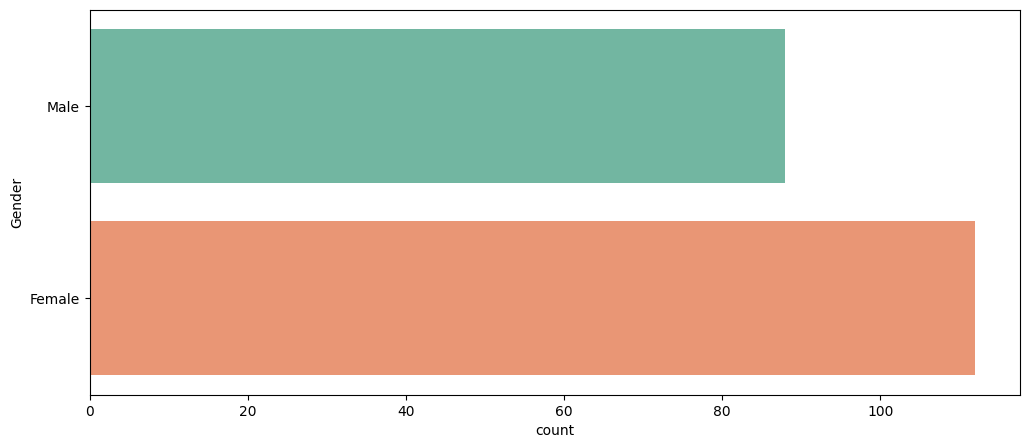

In [13]:
# target balance 확인
text = "gender balance"
print('{:-^50}'.format(text))
print(df['Gender'].value_counts() / df.shape[0])
print(f'{"-"*len(text):-^50}')   

plt.figure(figsize=(12, 5))
sns.countplot(df_raw['Gender'], palette='Set2')

-----------------Age Distribution-----------------
Age Mean : 38.85
Age Median : 36.0
--------------------------------------------------


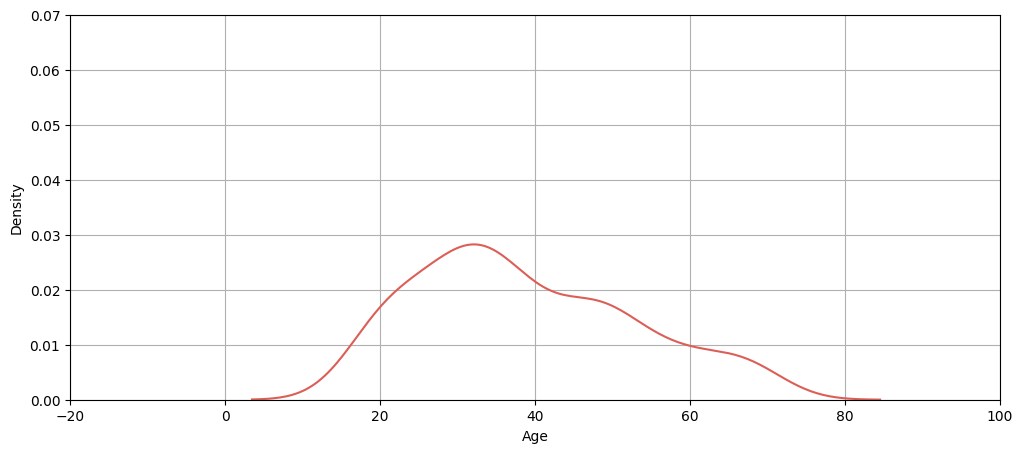

In [18]:
# Age Distribution.
text = "Age Distribution"
print('{:-^50}'.format(text))
print(f"Age Mean : {df['Age'].mean()}")
print(f"Age Median : {df['Age'].median()}")
print(f'{"-"*len(text):-^50}')   

plt.figure(figsize=(12, 5))
sns.kdeplot(df['Age'])
plt.xlim(-20,100)
plt.ylim(0.0,0.07)
plt.grid(True)

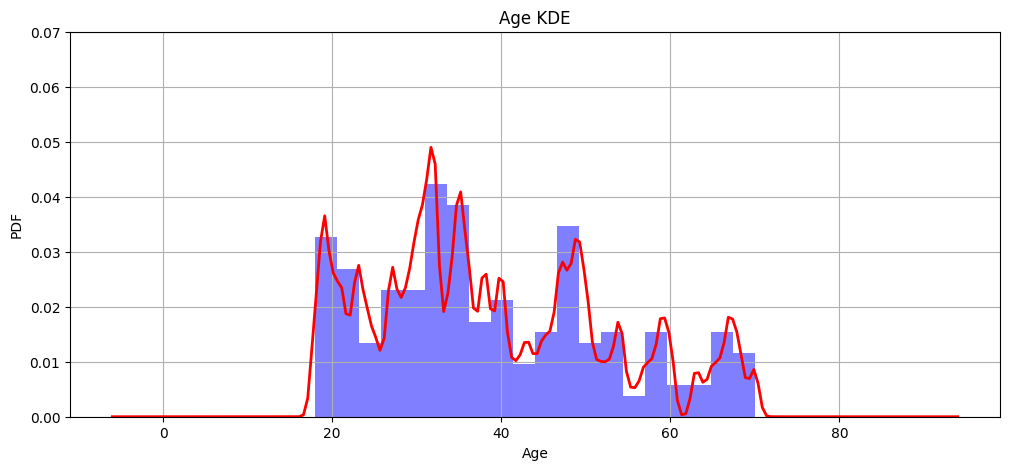

In [16]:
kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
kde.fit(df['Age'].values.reshape(200,1))
x_grid = np.linspace(df['Age'].min()-14-10, df['Age'].max()+14+10, 200)
log_dens = kde.score_samples(x_grid.reshape(-1, 1))
pdf = np.exp(log_dens)
plt.figure(figsize=(12, 5))
plt.hist(df["Age"], bins=20, density=True, alpha=0.5, color='b')
plt.plot(x_grid, pdf, 'r', linewidth=2)
plt.title(f'{df["Age"].name} KDE')
plt.ylim(0.0,0.07)
plt.xlabel(df["Age"].name)
plt.ylabel('PDF')
plt.grid(True)
plt.show()

추정 평균: 38.85, 추정 표준편차: 13.93


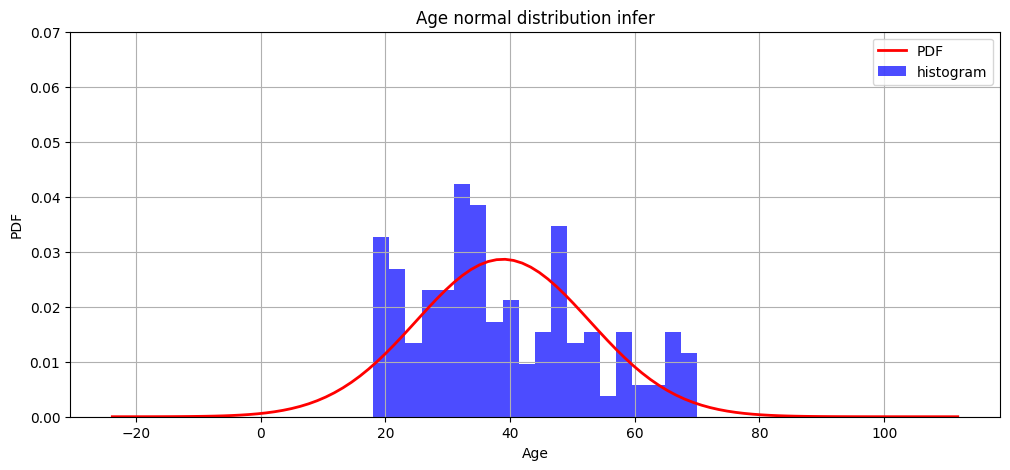

In [17]:
# 정규분포를 추정
mu, std = norm.fit(df["Age"])
print(f'추정 평균: {mu:.2f}, 추정 표준편차: {std:.2f}')

# PDF의  Age 값 범위 생성
x_grid = np.linspace(df["Age"].min() - 3*std, df["Age"].max() + 3*std, 100)

# 정규 분포 PDF 계산
pdf = norm.pdf(x_grid, mu, std)

# PDF 시각화
plt.figure(figsize=(12, 5))
plt.hist(df["Age"], bins=20, density=True, alpha=0.7, color='b')
plt.plot(x_grid, pdf, 'r', linewidth=2) 
plt.title(f'Age normal distribution infer')
plt.ylim(0.0,0.07)
plt.xlabel("Age")
plt.ylabel('PDF')
plt.legend(['PDF', 'histogram'])
plt.grid(True)
plt.show()

In [ ]:
# coefficients = np.polyfit(df["Age"].values, df["Annual Income (k$)"].values, 2)
# polynomial = np.poly1d(coefficients)
# y_infer_2d = polynomial(df["Age"])
# plt.plot(df["Age"], y_infer_2d, color='red', label=f'Infer (y={coefficients[0]:.2f}x + {coefficients[1]:.2f})')

Text(0.5, 1.0, 'scatter & Inference Estimatation line : FeMale')

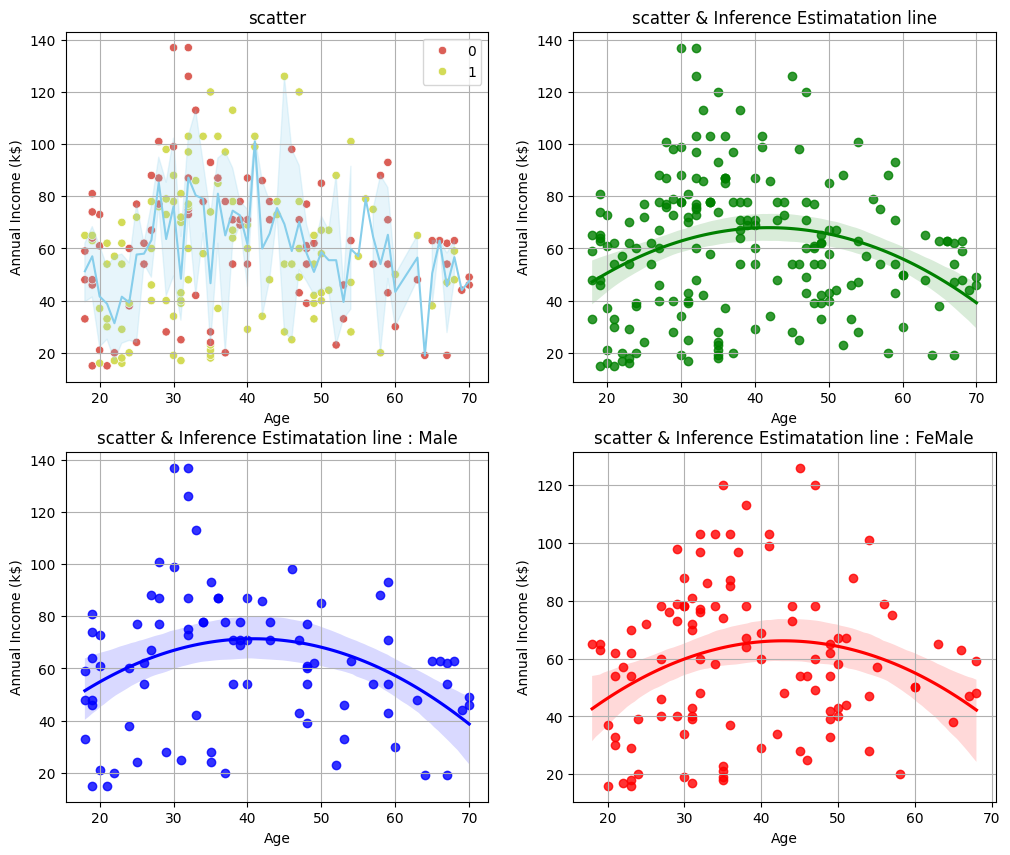

In [19]:
# scatter plot by x='Age', y='Annual Income'

y_male = df[df["Gender"]==0]
y_female = df[df["Gender"]==1]

fig, axs = plt.subplots(2,2,figsize=(12, 10))
sns.scatterplot(x='Age', y='Annual Income (k$)', data=df, hue='Gender', ax=axs[0,0])
sns.lineplot(x='Age', y='Annual Income (k$)', data=df, color = 'skyblue', ax=axs[0,0]).grid()
axs[0,0].set_title("scatter")
sns.regplot(x='Age', y='Annual Income (k$)', data=df, order=2, color='g', ax=axs[0,1]).grid()
axs[0,1].set_title("scatter & Inference Estimatation line")
sns.regplot(x='Age', y='Annual Income (k$)', data=y_male, order=2, color='b', ax=axs[1,0]).grid()
axs[1,0].set_title("scatter & Inference Estimatation line : Male")
sns.regplot(x='Age', y='Annual Income (k$)', data=y_female, order=2, color='r', ax=axs[1,1]).grid()
axs[1,1].set_title("scatter & Inference Estimatation line : FeMale")


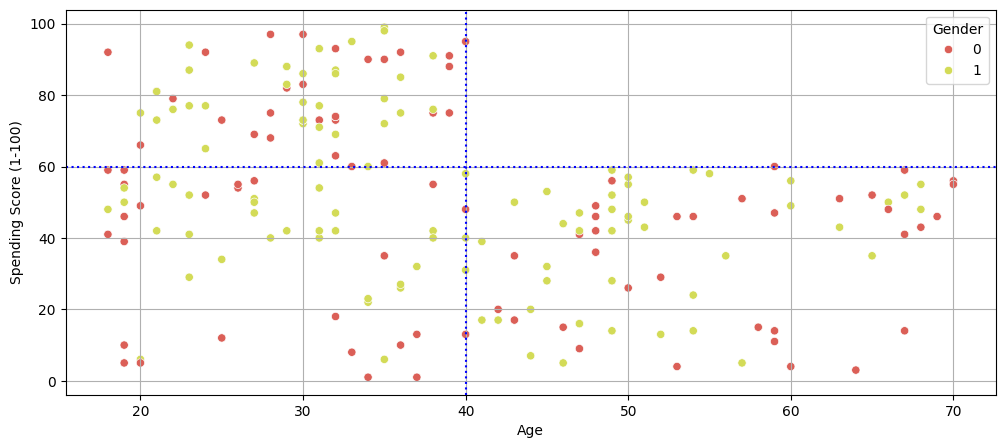

In [ ]:
regplot(x='Age', y='Annual Income (k$)', data=df, order=2, color='g', ax=axs[0,1]).grid()

plt.figure(figsize=(12, 5))
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=df, hue='Gender').grid()
plt.axvline(40, 0, 100, ls=':', color='b')
plt.axhline(60, 0, 80, ls=':', color='b')

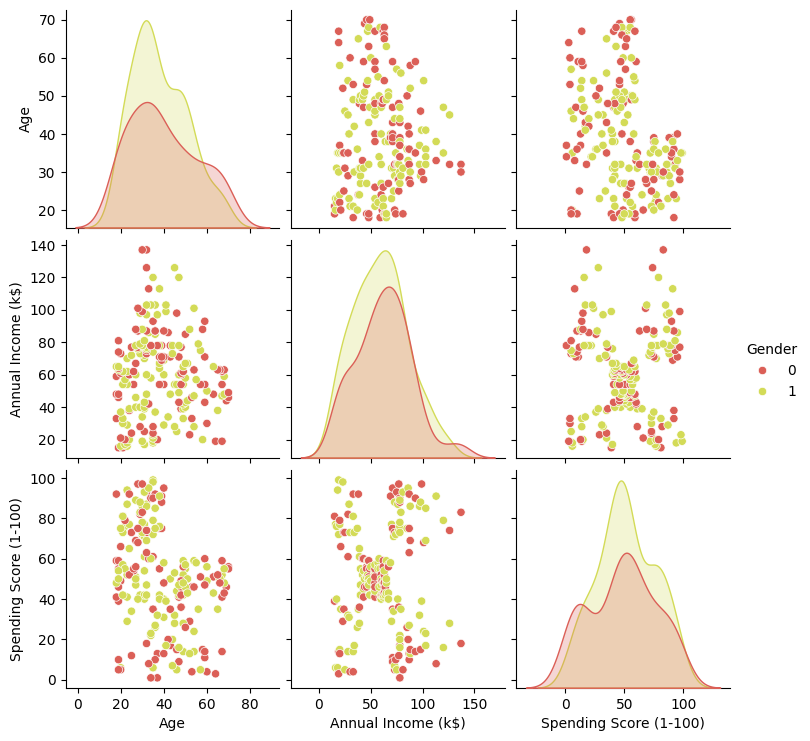

In [25]:
# sns.pairplot(df, kind="kde")
# sns.pairplot(df, hue="Gender", kind="kde")
g = sns.pairplot(df, hue="Gender", diag_kind="kde")
# g.map_lower(sns.kdeplot, levels=4, color='.2')

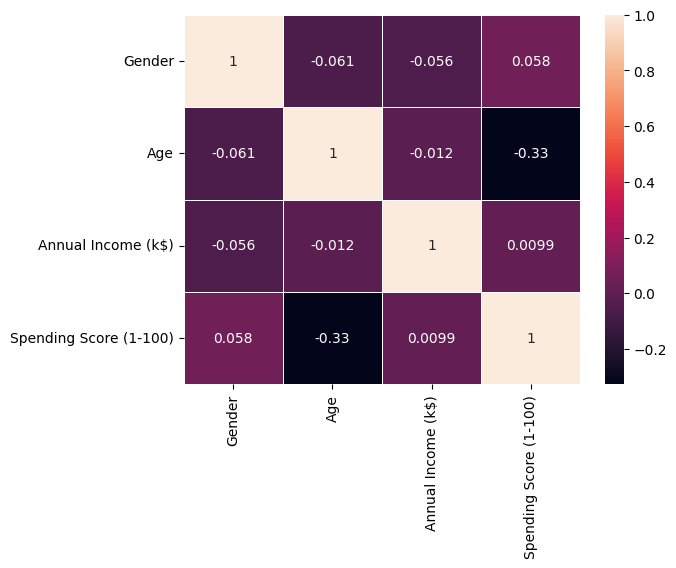

In [26]:
g = sns.heatmap(df.corr(), annot=True, linewidths=.5)
# bottom, top = g.get_ylim()
# g.set_ylim(bottom+0.5, top-0.5)

#####  (1) Hierarchical Clustering

- 거리측정 방식
    1) 원소간 거리
        - L1 norm (manhattan distance)
        - L2 norm (euclidean distance)
        - mahalanobis (feature간의 공분산 행렬을 고려한 거리)
        - corr distance (상관계수 높을수록 거리 짧게)
    2) 군집과 군집 사이 거리
        - single linkage (군집 간 element끼리의 거리 중 min을 군집 간 거리로 설정)
        - complete linkage (군집 간 element끼리의 거리 중 max를 군집 간 거리로 설정)
        - average linkage (군집 간 element끼리의 모든 거리를 average)
        - centroid (군집의 centroid끼리의 거리)
        - ward (두 군집 간 제곱합 - (군집 내 제곱합의 합)) 

- bottom up (ex: AgglomerativeClustering -> proximity matrix에서 점점 군집의 크기를 키워나감)
- top down

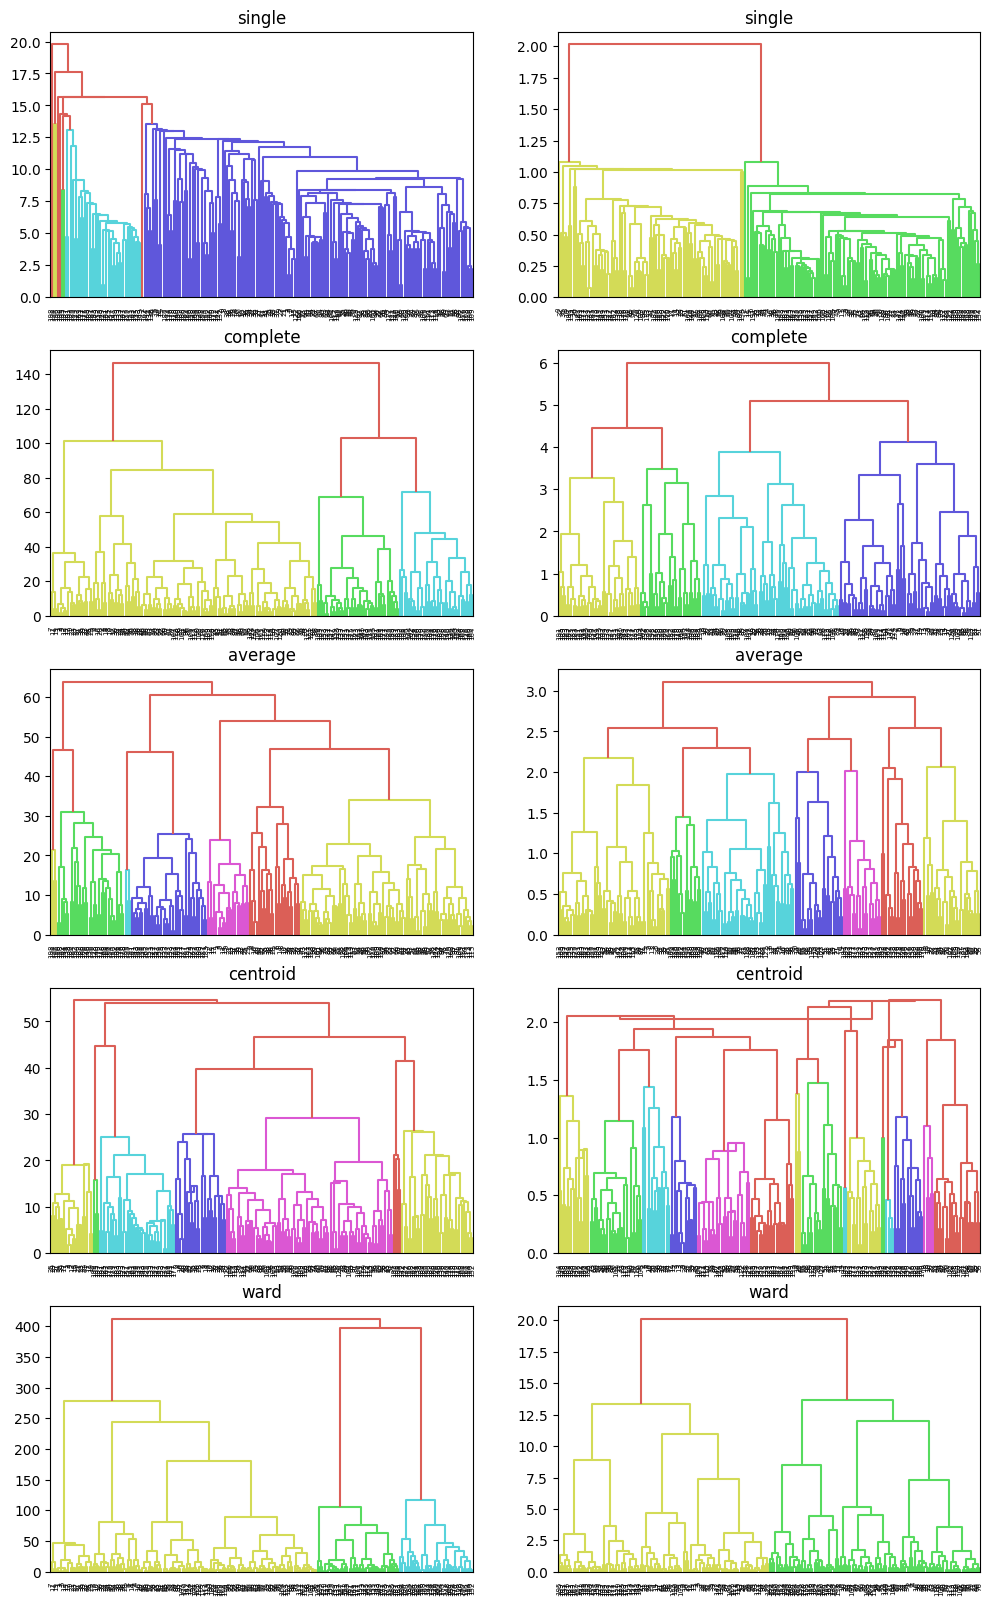

In [27]:
linkage_list = ['single', 'complete', 'average', 'centroid', 'ward']
data = [df, scaled_df]

fig, axes = plt.subplots(nrows=len(linkage_list), ncols=2, figsize=(12, 20))
for i in range(len(linkage_list)):
    for j in range(len(data)):
        hierarchical_single = linkage(data[j], method=linkage_list[i])
        dn = dendrogram(hierarchical_single, ax=axes[i][j])
        axes[i][j].title.set_text(linkage_list[i])
plt.show()

<Axes: xlabel='Age', ylabel='Annual Income (k$)'>

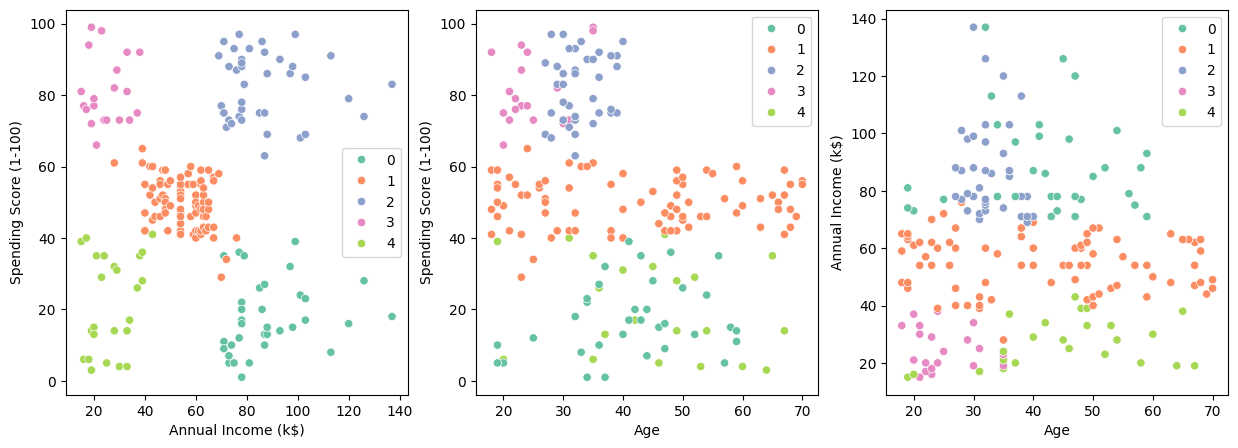

In [28]:
agg_clustering = AgglomerativeClustering(n_clusters=5, linkage='average')
labels = agg_clustering.fit_predict(df)

fig, axs = plt.subplots(1,3, figsize=(15,5))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df, hue=labels, palette='Set2', ax=axs[0])#.grid()
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=df, hue=labels, palette='Set2', ax=axs[1])#.grid()
sns.scatterplot(x='Age', y='Annual Income (k$)', data=df, hue=labels, palette='Set2', ax=axs[2])#.grid()

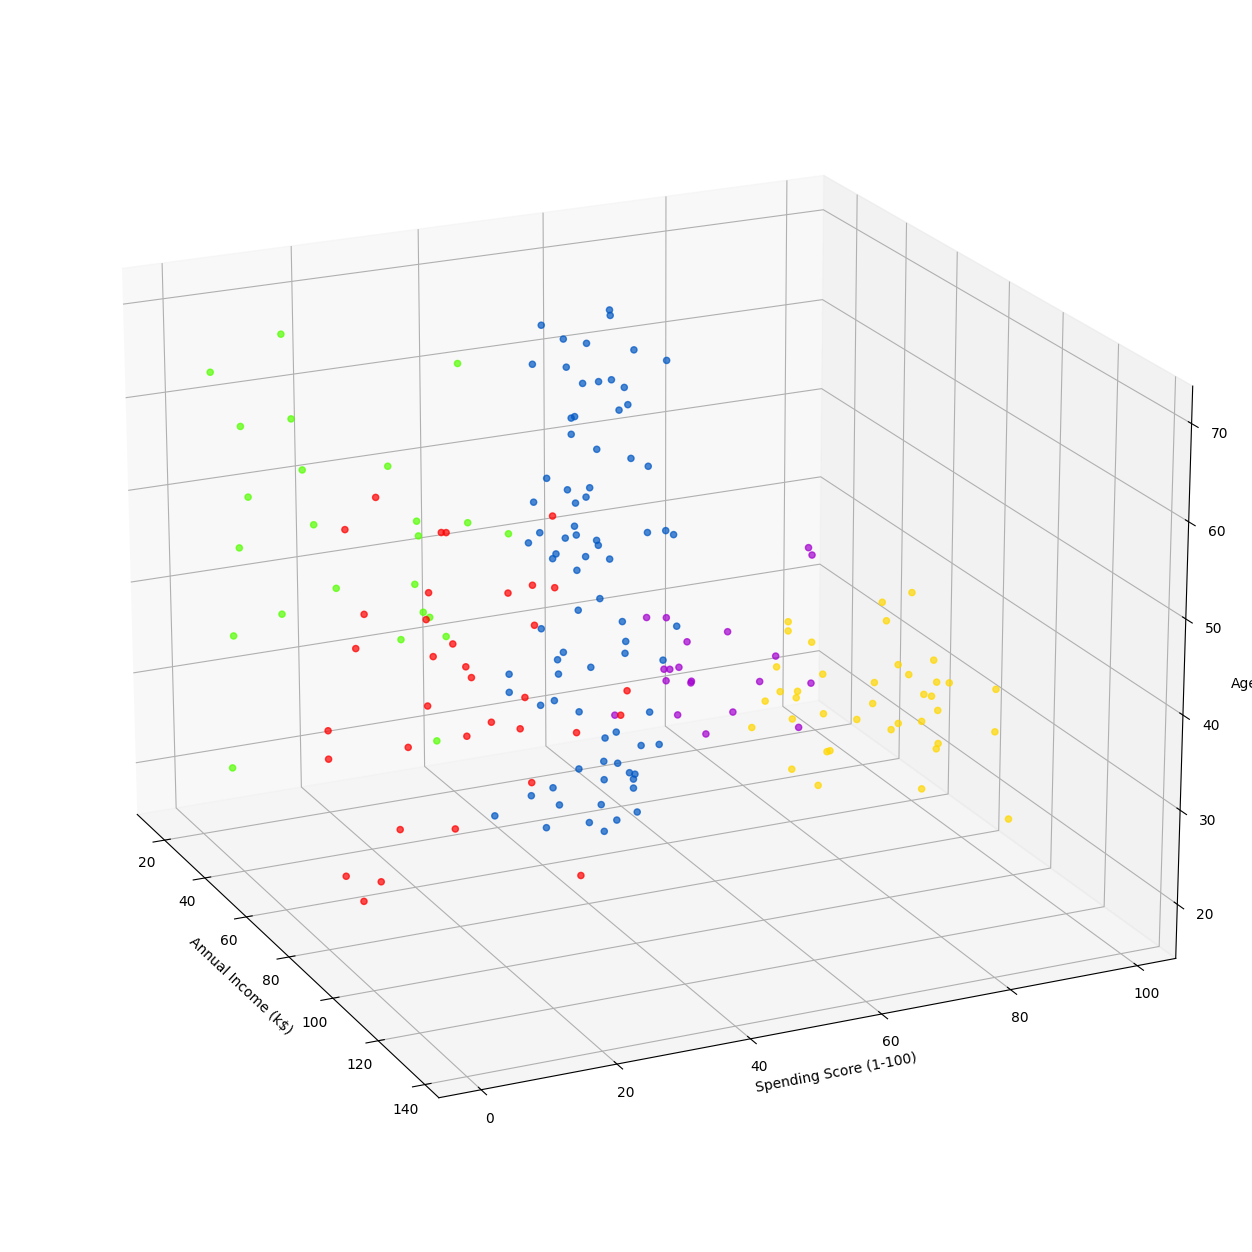

In [32]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d') 
x = df['Annual Income (k$)']
y = df['Spending Score (1-100)']
z = df['Age']
ax.set_xlabel('Annual Income (k$)')
ax.set_ylabel('Spending Score (1-100)')
ax.set_zlabel('Age') #, rotation=90)
ax.scatter(x, y, z, c = labels, s= 20, alpha=0.7, cmap='prism') #gist_rainbow, gnuplot, turbo, Set2
ax.view_init(elev=20, azim=-25, roll=0)

In [34]:
for k in range(2,7):
    agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='average')
    labels = agg_clustering.fit_predict(df)
    silScore= silhouette_score(df, labels)
    print(f"n_cluster = {k} : silhouette index {silScore}")

# 평가 방법이 의미하는 바를 생각해 보자.

n_cluster = 2 : silhouette index 0.31577520928038805
n_cluster = 3 : silhouette index 0.3812859576468096
n_cluster = 4 : silhouette index 0.4102091359195185
n_cluster = 5 : silhouette index 0.43521075902386996
n_cluster = 6 : silhouette index 0.4184037015474744


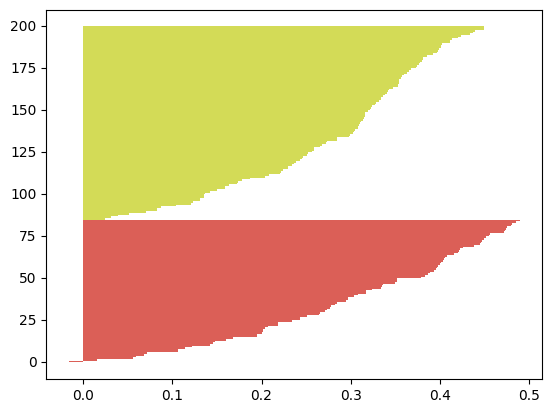

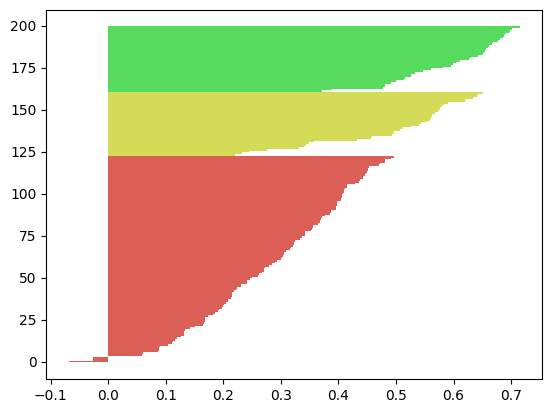

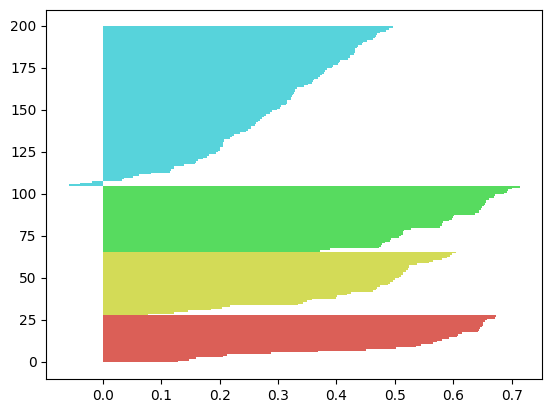

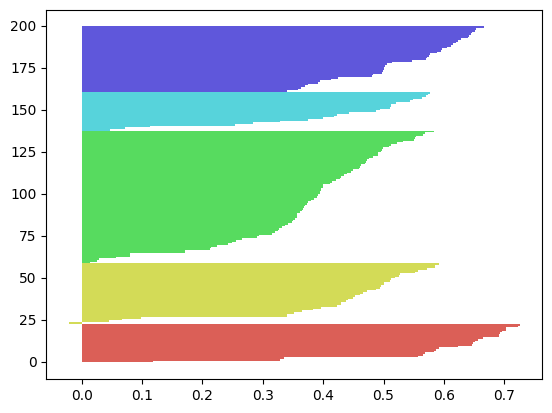

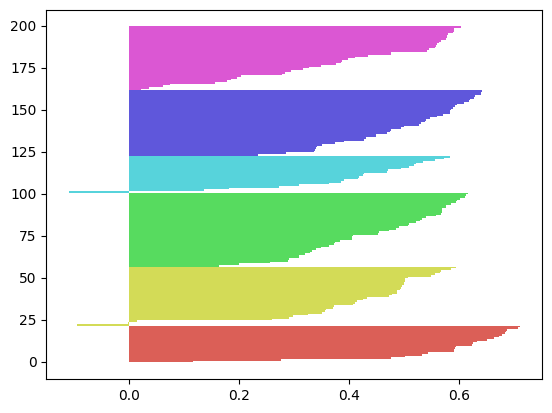

In [49]:
for k in range(2, 7):
    fig, ax = plt.subplots(1, 1)
    kmeans = KMeans(n_clusters=k, random_state=7).fit(df)
    silhouette_vals = silhouette_samples(df, kmeans.labels_)
    y_ticks = []
    y_lower = y_upper = 0
    for c_num in np.unique(kmeans.labels_):
        cluster_silhouette_vals = silhouette_vals[kmeans.labels_==c_num]
        y_upper += len(cluster_silhouette_vals)
        cluster_silhouette_vals.sort() # numpy array는 sort 메소드를 이용하면 오름차순으로 정렬된 형태로 바뀜
        
        ax.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1)
        y_lower += len(cluster_silhouette_vals)

#####  (2) KMeans

    - 중심 기반 군집화 (Centroid-based) - 거리기반
    - scikit learn : KMeans ‘k-means++’ 을 사용하여 초기 centroid 결정 
     (하나의 centroid 부터 시작하여 개수와 거기를 증가 시키며 최적 centroid 결정, 최종 cluster 내의 원소 간 거리 제곱합이 급격히 줄지 않는 지점 : elbow point - PCA 에서도 비슷하게 쓰음)


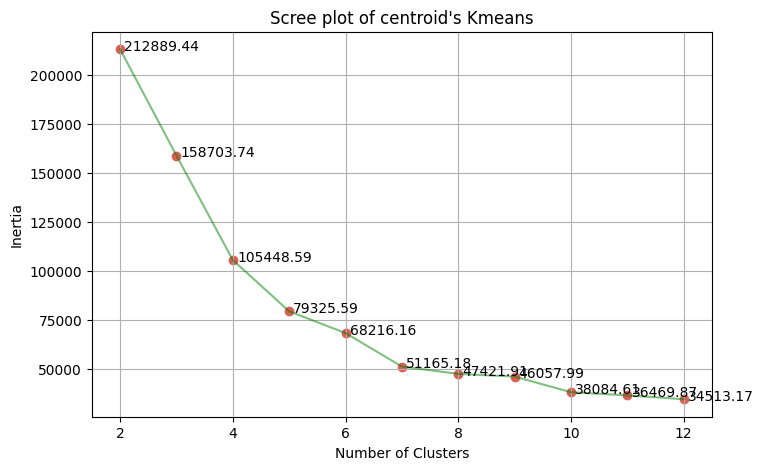

In [44]:
def centroid_fit(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
    fig, ax = plt.subplots(1,1,figsize = (8, 5))
    ax.scatter(n_clusters , sum_of_squared_distance , marker='o')
    ax.plot(n_clusters , sum_of_squared_distance , '-', color='g' , alpha = 0.5)
    for i, j in zip(n_clusters, sum_of_squared_distance):
        ax.annotate(str(round(j,2)), xy=(i,j), xytext=(3,-3), textcoords='offset points', ha='left', va='bottom')
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel('Inertia')
    ax.set_title("Scree plot of centroid's Kmeans")
    ax.grid()
    return n_clusters, sum_of_squared_distance

n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

clst = centroid_fit(n_clusters, df)

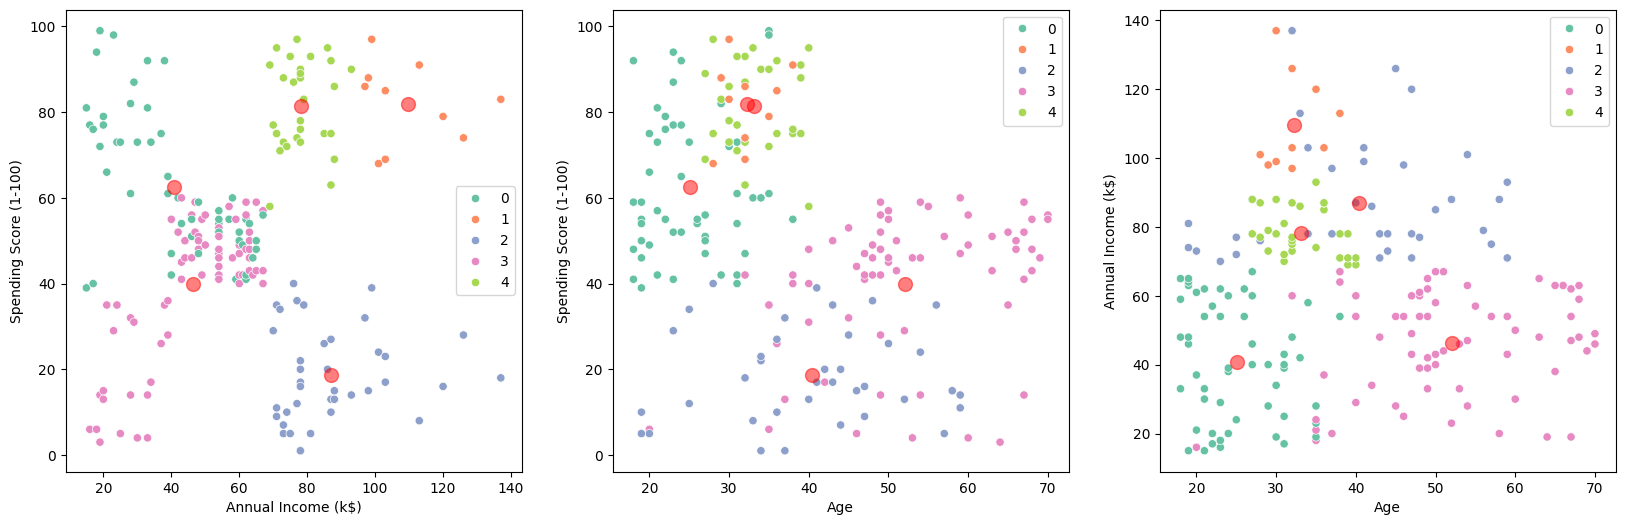

In [47]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df)

fig, axs = plt.subplots(1,3,figsize=(20, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df, hue=kmeans.labels_, palette='Set2', ax=axs[0])
axs[0].scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 3], c='red', alpha=0.5, s=100)
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=df, hue=kmeans.labels_, palette='Set2', ax=axs[1])
axs[1].scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 3], c='red', alpha=0.5, s=100)
sns.scatterplot(x='Age', y='Annual Income (k$)', data=df, hue=kmeans.labels_, palette='Set2', ax=axs[2])
axs[2].scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], c='red', alpha=0.5, s=100)

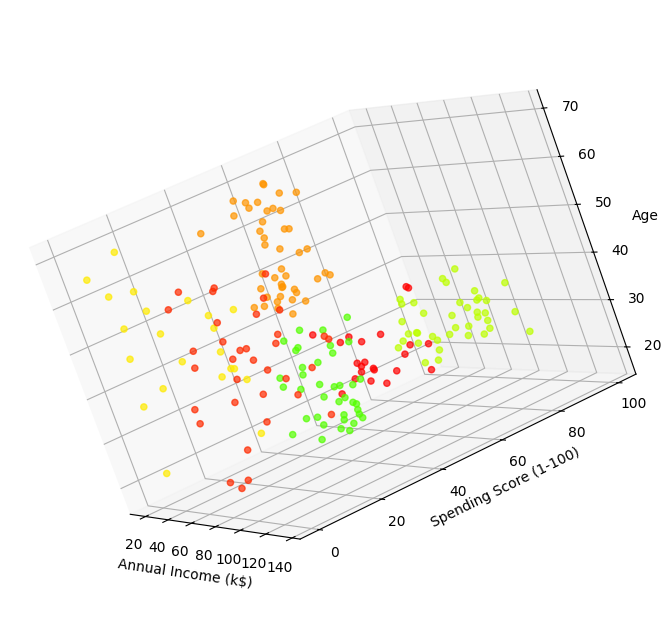

In [50]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d') 
x = df['Annual Income (k$)']
y = df['Spending Score (1-100)']
z = df['Age']
ax.set_xlabel('Annual Income (k$)')
ax.set_ylabel('Spending Score (1-100)')
ax.set_zlabel('Age') #, rotation=90)
ax.scatter(x, y, z, c = kmeans.labels_, s= 20, alpha=0.7, cmap='prism') #gist_rainbow, gnuplot, turbo, Set2
ax.view_init(elev=10, azim=-25, roll=20)

#####  (3) DBSCAN

    - 최근접 이웃법을 사용하여 epsilon 과 centroid k 이용하여 적정한 하이퍼 파라메터를 구한다.

10.246950765959598
13.490737563232042
17.916472867168917
17.406895185529212
 average : 12.888414033243057


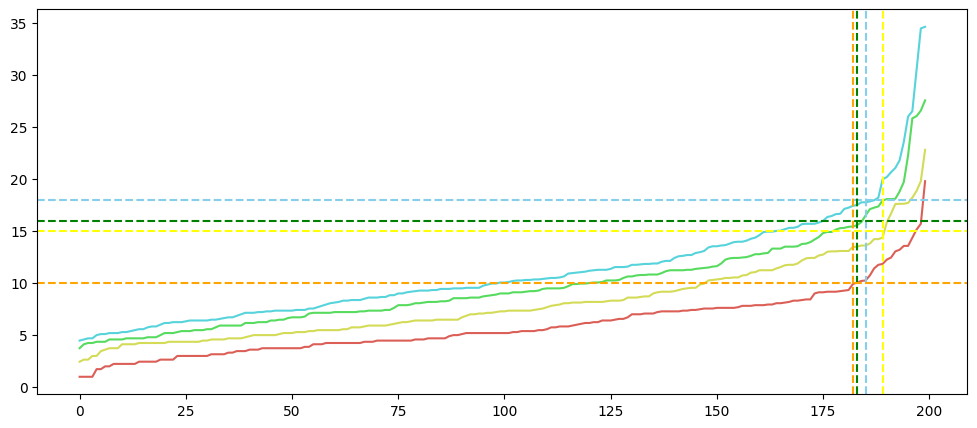

In [51]:
# 최근접 이웃법으로 각 데이터의 최근접 이웃 5개 확인
nstn = NearestNeighbors(n_neighbors=5) 
nstn.fit(df)
# 그때의 거리와 포인티
distances, indices = nstn.kneighbors(df)

# def moving_average(data, window_size):
#     s = pd.Series(data)
#     return s.rolling(window=window_size).mean().dropna().to_numpy()

dist_1 = (185,18)
dist_2 = (183,16)
dist_3 = (189,15)
dist_4 = (182,10)

fig, ax = plt.subplots(1,1, figsize=(12, 5))
for i in range(1, distances.shape[1]): # 첫번째 컬럼은 포인트의 위치
    i_nstn = np.sort(distances[:,i])
    ax.plot(i_nstn)
ax.axvline(dist_1[0], 0, 2, ls='--', c = 'skyblue', label='dist-1')
ax.axhline(dist_1[1], 0, 200, ls='--', c = 'skyblue')
ax.axvline(dist_2[0], 0, 2, ls='--', c = 'green', label='dist-2')
ax.axhline(dist_2[1], 0, 200, ls='--', c = 'green')
ax.axvline(dist_3[0], 0, 2, ls='--', c = 'yellow', label='dist-3')
ax.axhline(dist_3[1], 0, 200, ls='--', c = 'yellow')
ax.axvline(dist_4[0], 0, 2, ls='--', c = 'orange', label='dist-4')
ax.axhline(dist_4[1], 0, 200, ls='--', c = 'orange')
print(np.sort(distances[:, 1])[dist_1[0]])
print(np.sort(distances[:, 2])[dist_2[0]])
print(np.sort(distances[:, 3])[dist_3[0]])
print(np.sort(distances[:, 4])[dist_4[0]])
print(f" average : {((np.sort(distances[:, 1])[dist_1[0]]) + np.sort(distances[:, 2])[dist_2[0]]+ np.sort(distances[:, 3])[dist_3[0]]+ np.sort(distances[:, 1])[dist_4[0]])/4}")

[-1  0  1  2  3  4]


<Axes: xlabel='Age', ylabel='Annual Income (k$)'>

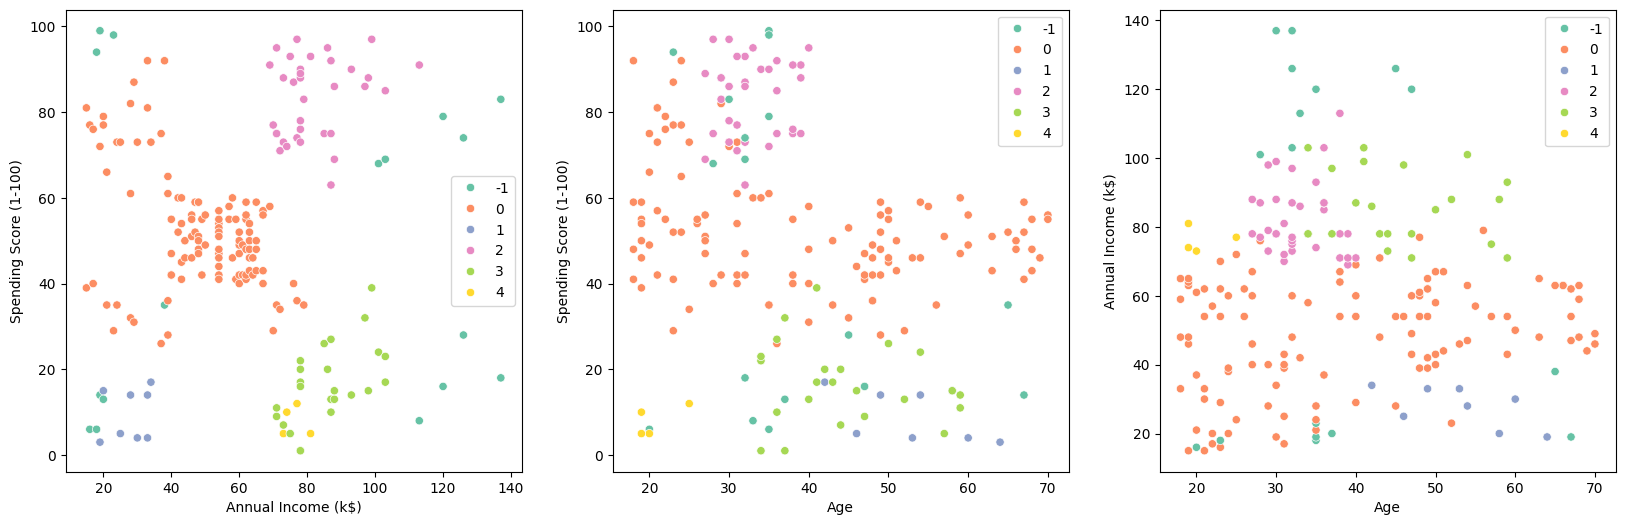

In [57]:
dbscan = DBSCAN(eps=12.8, min_samples=4)
dbscan.fit(df)
print(np.unique(dbscan.labels_))

fig, axs = plt.subplots(1,3,figsize=(20, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df, hue=dbscan.labels_, palette='Set2', ax=axs[0])
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=df, hue=dbscan.labels_, palette='Set2', ax=axs[1])
sns.scatterplot(x='Age', y='Annual Income (k$)', data=df, hue=dbscan.labels_, palette='Set2', ax=axs[2])


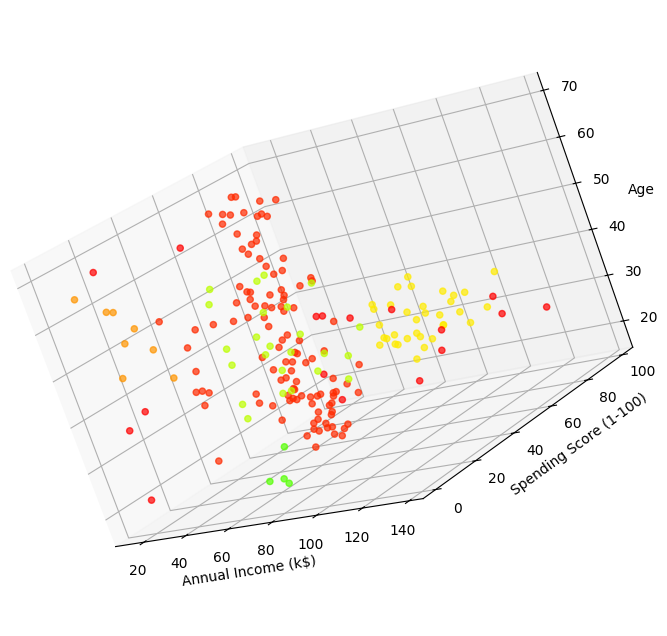

In [59]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d') 
x = df['Annual Income (k$)']
y = df['Spending Score (1-100)']
z = df['Age']
ax.set_xlabel('Annual Income (k$)')
ax.set_ylabel('Spending Score (1-100)')
ax.set_zlabel('Age') #, rotation=90)
ax.scatter(x, y, z, c = dbscan.labels_, s= 20, alpha=0.7, cmap='prism') #gist_rainbow, gnuplot, turbo, Set2
ax.view_init(elev=10, azim=-50, roll=20)

#### (4) GMM

In [60]:
init_centers = np.array([kmeans.cluster_centers_[0,:], kmeans.cluster_centers_[1,:], kmeans.cluster_centers_[2,:], kmeans.cluster_centers_[3,:], kmeans.cluster_centers_[4,:]])
gmm = GaussianMixture(n_components=5, covariance_type='full', means_init=init_centers,  random_state=100)
gmm.fit(df)
gmm_labels = gmm.predict(df)

[0 1 2 3 4]


<Axes: xlabel='Age', ylabel='Annual Income (k$)'>

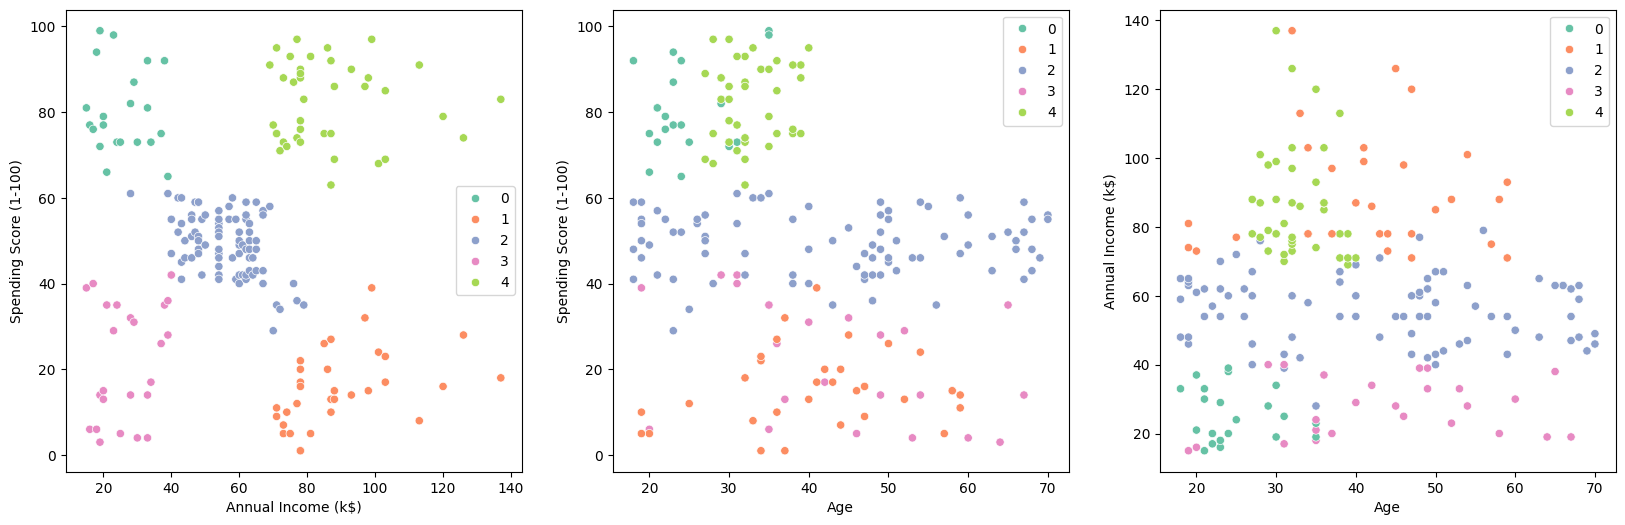

In [61]:
print(np.unique(gmm_labels))

fig, axs = plt.subplots(1,3,figsize=(20, 6))
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df, hue=gmm_labels, palette='Set2', ax=axs[0])
sns.scatterplot(x='Age', y='Spending Score (1-100)', data=df, hue=gmm_labels, palette='Set2', ax=axs[1])
sns.scatterplot(x='Age', y='Annual Income (k$)', data=df, hue=gmm_labels, palette='Set2', ax=axs[2])


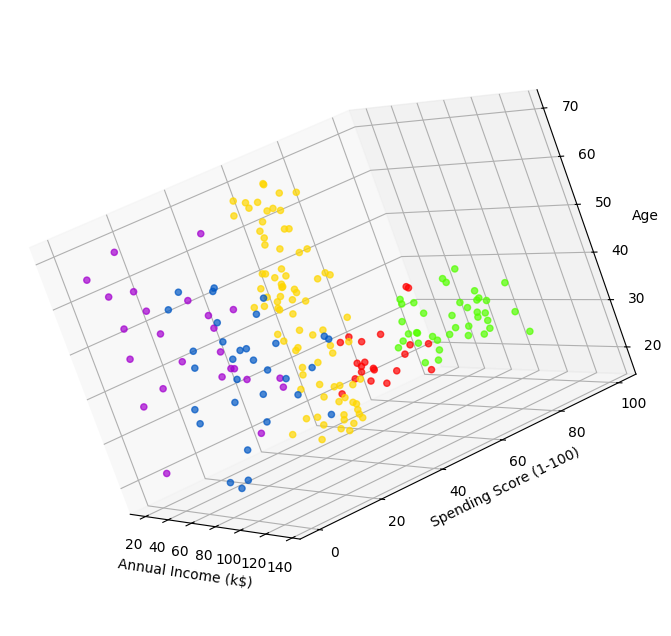

In [62]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d') 
x = df['Annual Income (k$)']
y = df['Spending Score (1-100)']
z = df['Age']
ax.set_xlabel('Annual Income (k$)')
ax.set_ylabel('Spending Score (1-100)')
ax.set_zlabel('Age') #, rotation=90)
ax.scatter(x, y, z, c = gmm_labels, s= 20, alpha=0.7, cmap='prism') #gist_rainbow, gnuplot, turbo, Set2
ax.view_init(elev=10, azim=-25, roll=20)

#### (5) Evaluation : Silhoutte Score

In [65]:
def visualize_silhouette(clustering, X_features, cluster_lists=[1]): 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    for ind, n_cluster in enumerate(cluster_lists):
        if clustering[0] == 'hierarchical':
            model = AgglomerativeClustering(n_clusters=n_cluster, linkage=clustering[1])
        elif clustering[0] == 'kmeans':
            model = KMeans(n_clusters=n_cluster)
        cluster_labels = model.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([-1, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [67]:
params = {
    'linkage':['single', 'complete', 'average', 'ward'],
    'n_clusters':[2, 3, 4, 5, 6, 7]}

scores_hierarcical= {}
for linkage in params['linkage']:
    for n_cluster in params['n_clusters']:
        hierarchical = AgglomerativeClustering(n_clusters=n_cluster, linkage=linkage)
        hierarchical.fit(df)
        score = silhouette_score(df, hierarchical.labels_)
        scores_hierarcical['_'.join(['original', linkage, str(n_cluster)])] = score
        
        hierarchical = AgglomerativeClustering(n_clusters=n_cluster, linkage=linkage)
        hierarchical.fit(scaled_df)
        score = silhouette_score(scaled_df, hierarchical.labels_)
        scores_hierarcical['_'.join(['scaling', linkage, str(n_cluster)])] = score

pd.Series(scores_hierarcical).sort_values(ascending=False)[:10]


original_ward_6        0.442801
original_ward_5        0.439975
original_complete_5    0.439975
original_average_5     0.435211
original_ward_7        0.425939
original_complete_6    0.423266
original_average_6     0.418404
original_complete_7    0.414121
original_complete_4    0.410209
original_ward_4        0.410209
dtype: float64

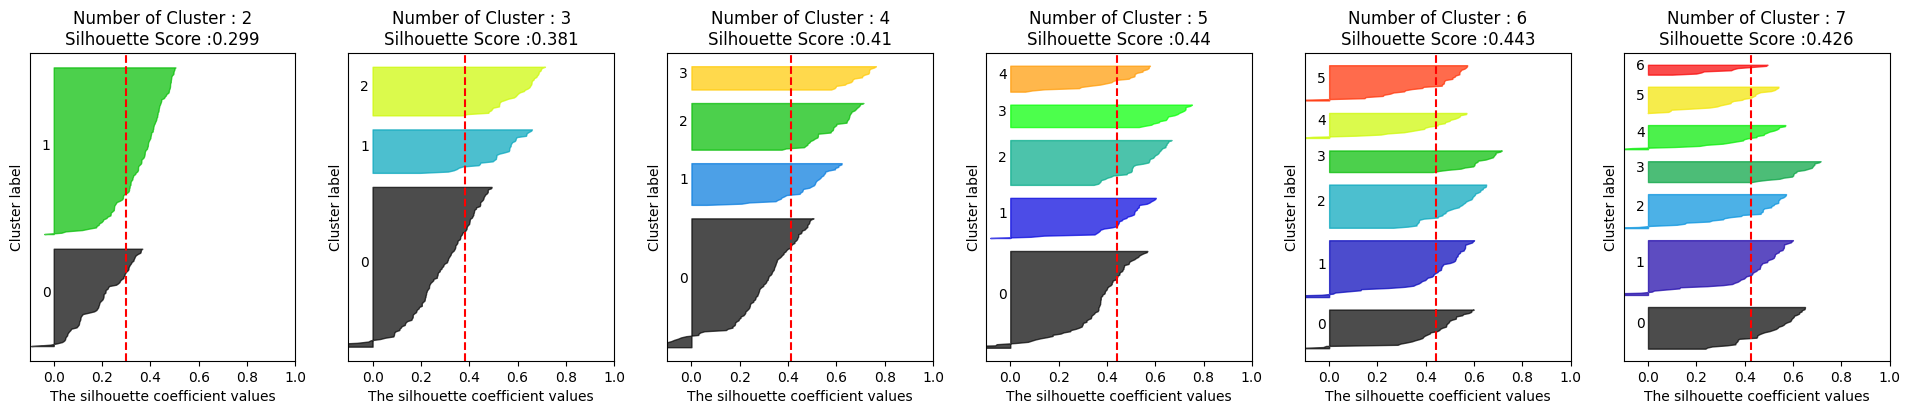

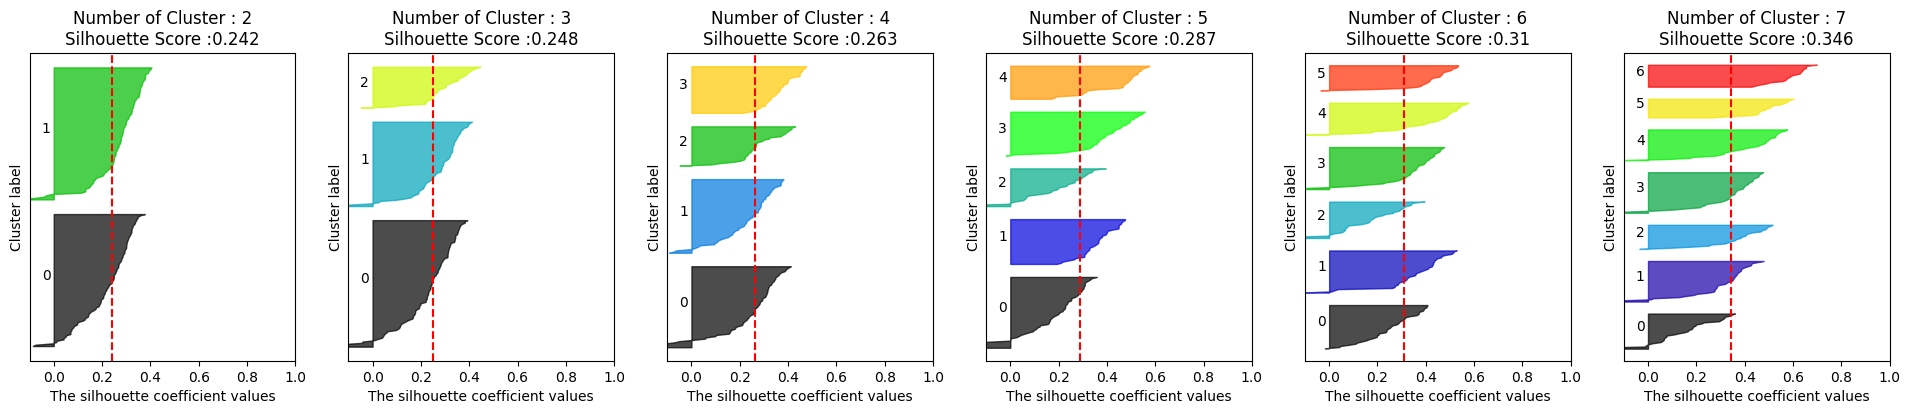

In [68]:

visualize_silhouette(['hierarchical', 'ward'], df, [2, 3, 4, 5, 6, 7]) # 위가 original data
visualize_silhouette(['hierarchical', 'ward'], scaled_df, [2, 3, 4, 5, 6, 7]) # 아래가 scaled data


In [69]:

dbscan = DBSCAN(eps=13, min_samples=4)
dbscan.fit(df)
print( silhouette_score(df, dbscan.labels_) ) # 실제로는 1개의 군집이기 때문에 silhouette score가 계산이 안되어야 한다고 생각한다.
# print(print( silhouette_score(mall_df[dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1]) )) # noise 제외한 silhouette score

dbscan = DBSCAN(eps=1.07, min_samples=4)
dbscan.fit(scaled_df)
print( silhouette_score(scaled_df, dbscan.labels_) ) # noise를 하나의 군집으로 여기고 silhouette score 계산 (인 것 같다)
print( silhouette_score(scaled_df[dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1]) ) # noise 제외한 silhouette score


0.14759656888751402
0.2652046618498847
0.2835273023622371


#### (6) PCA

In [ ]:
pca = PCA(n_components=4)
pca.fit(df)

In [ ]:
print('성분 벡터')
print(pca.components_)
print()
 
print('데이터 총 분산', np.sum(np.diag(pca.get_covariance())))
print('주성분의 분산', pca.explained_variance_)
print('분산 설명 비율', pca.explained_variance_ratio_)

In [ ]:
pc = pca.transform(df) ## principle factor (주성분)
# print(pc)
inverse_pc = pca.inverse_transform(pc)
# print(inverse_pc) 


#### (7)SOM